# Libraries and Helper Functions

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.cluster import KMeans
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD

In [206]:
def convert_categorical(df, column_name):
    dummy_columns = pd.get_dummies(df[column_name])
    df = pd.concat([df, dummy_columns], axis = 1)
    df = df.drop(column_name, axis = 1)
    return df

# Split Dataset

In [207]:
# load and split data
main_df = pd.read_csv('full_dataset.csv')
train_df, test_df = train_test_split(main_df, test_size = .2, random_state = 42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Train Size: (33692, 90)
Test Size: (8423, 90)


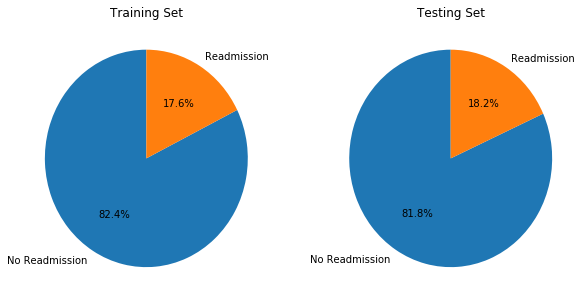

In [208]:
# print total size
print("Train Size: {0}".format(train_df.shape))
print("Test Size: {0}".format(test_df.shape))

# get class counts by dataset
train_no_readmission = train_df[train_df['READMISSION'] == False].shape[0]
train_readmission = train_df[train_df['READMISSION'] == True].shape[0]
test_no_readmission = test_df[test_df['READMISSION'] == False].shape[0]
test_readmission = test_df[test_df['READMISSION'] == True].shape[0]

# plot dataset splits
labels = ['No Readmission', 'Readmission']
train_graph_data = [train_no_readmission, train_readmission]
test_graph_data = [test_no_readmission, test_readmission]

fig = plt.figure(figsize=(10,5))
train_ax = fig.add_subplot(121)
train_ax.pie(train_graph_data, labels=['No Readmission', 'Readmission'], autopct='%1.1f%%', startangle = 90)
train_ax.set_title('Training Set')

test_ax = fig.add_subplot(122)
test_ax.pie(test_graph_data, labels=['No Readmission', 'Readmission'], autopct='%1.1f%%', startangle = 90)
test_ax.set_title('Testing Set')

plt.show()

In [209]:
# save train and test datasets
train_df.to_csv('train_dataset.csv', index = False)
test_df.to_csv('test_dataset.csv', index = False)

# Add Text Features

### Create TF-IDF

In [210]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [211]:
# create tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(max_df=.15, max_features=100000,
                             min_df=5, stop_words='english',
                             use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_df['DESCRIPTION'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_df['DESCRIPTION'])
terms = tfidf_vectorizer.get_feature_names()

### K-Means Cluster

#### Helper Functions

In [212]:
def get_vocab_frame(df, column_name):
    column = df[column_name]
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for j,i in column.iteritems():
        allwords_stemmed = tokenize_and_stem(i) #for each item in 'description', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
        #if len(totalvocab_stemmed) != len(totalvocab_tokenized):
        #    print(j)
        #    print(i)
    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
    return vocab_frame

In [213]:
def cluster_text(df_train, num_clusters, vocab_frame, tfidf_matrix, terms):
    
    #kmeans cluster
    km = KMeans(n_clusters=num_clusters, random_state = 42)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    df_train['cluster'] = clusters
    print('Cluster Value Counts:')
    print(df_train['cluster'].value_counts())
    
    #view clusters
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace

        cluster_classes = df_train[df_train['cluster'] == i]['READMISSION'].value_counts()
        cluster_classes = 1.0 * cluster_classes / df_train[df_train['cluster'] == i].shape[0]
        print(cluster_classes)
        print() #add whitespace
        print() #add whitespace

    print()
    print()
    
    return km

#### Clustering

In [214]:
# create vocab frame for cluster visualization
vocab_frame = get_vocab_frame(train_df,'DESCRIPTION')

there are 121780 items in vocab_frame


In [215]:
# run k-means clustering and input it into dataset
clusters = 7
km = cluster_text(train_df.copy(), clusters, vocab_frame, tfidf_matrix_train, terms)
train_df['DESCRIPTION_CLUSTER'] = km.predict(tfidf_matrix_train)
test_df['DESCRIPTION_CLUSTER'] = km.predict(tfidf_matrix_test)

Cluster Value Counts:
2    28018
4     1554
1     1332
6     1059
0      769
5      642
3      318
Name: cluster, dtype: int64
Top terms per cluster:

Cluster 0 words: septicemia, disseminated, disseminated, septicemia, septicemia, infections,

False    0.773732
True     0.226268
Name: READMISSION, dtype: float64


Cluster 1 words: cardiac, cardiac, cardiac, valve, valve, cardiac,

False    0.882883
True     0.117117
Name: READMISSION, dtype: float64


Cluster 2 words: trauma, craniotomy, craniotomy, hemorrhage, vascular, disorders,

False    0.807945
True     0.192055
Name: READMISSION, dtype: float64


Cluster 3 words: large, bowel, small, small, small, large,

False    0.779874
True     0.220126
Name: READMISSION, dtype: float64


Cluster 4 words: neonate, problem, newborn, normal, normal, normal,

False    0.972973
True     0.027027
Name: READMISSION, dtype: float64


Cluster 5 words: cardiac, bypass, bypass, w/, coronary, w/,

False    0.9081
True     0.0919
Name: READMISSION, dty

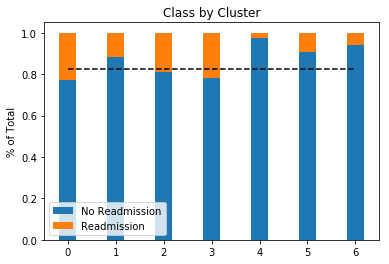

In [216]:
# get cluster summmary for graph
no_readmission_cluster = train_df[train_df['READMISSION'] == False]['DESCRIPTION_CLUSTER'].value_counts()
readmission_cluster = train_df[train_df['READMISSION'] == True]['DESCRIPTION_CLUSTER'].value_counts()
cluster_summary = [[cluster, no_readmission_cluster[cluster], readmission_cluster[cluster]] for cluster in range(clusters)]
cluster_summary = pd.DataFrame(cluster_summary, columns=['Cluster', 'No Readmission', 'Readmission'])
cluster_summary['Total'] = cluster_summary['No Readmission'] + cluster_summary['Readmission']
cluster_summary['No Readmission'] = 1.0 * cluster_summary['No Readmission'] / cluster_summary['Total']
cluster_summary['Readmission'] = 1.0 * cluster_summary['Readmission'] / cluster_summary['Total']

# graph cluster summary
ind = np.arange(clusters)
labels = ind

fig, ax = plt.subplots()

no_readmission_axis = ax.bar(ind, cluster_summary['No Readmission'].tolist(), label = 'No Readmission', width = width)
readmission_axis = ax.bar(ind, cluster_summary['Readmission'].tolist(), bottom = cluster_summary['No Readmission'].tolist(), label = 'Readmission', width = width)

ax.set_ylabel('% of Total')
ax.set_title('Class by Cluster')
ax.set_xticks(ind)
ax.set_xticklabels(labels)

ax.legend((no_readmission_axis[0], readmission_axis[0]), ('No Readmission', 'Readmission'))

ax.plot([0, 6], [(1.0*train_no_readmission / train_df.shape[0]), (1.0*train_no_readmission / train_df.shape[0])], "k--")

plt.show()

In [217]:
# format cluster labels
train_df['DESCRIPTION_CLUSTER'] = train_df['DESCRIPTION_CLUSTER'].apply(lambda x: 'Text Cluster - {0}'.format(x))
test_df['DESCRIPTION_CLUSTER'] = test_df['DESCRIPTION_CLUSTER'].apply(lambda x: 'Text Cluster - {0}'.format(x))

train_df = convert_categorical(train_df, 'DESCRIPTION_CLUSTER')
test_df = convert_categorical(test_df, 'DESCRIPTION_CLUSTER')

# PCA

In [218]:
# calculate PCA explained variance ratio for a number of different component levels
X_pca = []
y_pca = []
max_components = 500
pca = TruncatedSVD(n_components=max_components)
pca.fit(tfidf_matrix_train)
for i in range(max_components):
    explained_ratio = pca.explained_variance_ratio_[:(i + 1)].sum()
    X_pca.append(i)
    y_pca.append(explained_ratio)

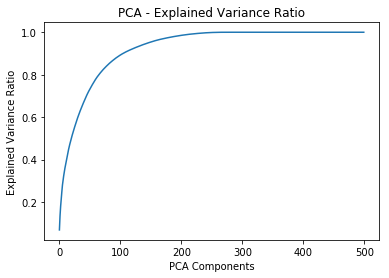

In [219]:
# plot pca explained variance ratio
fig, ax = plt.subplots()

ax.plot(X_pca, y_pca)
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA - Explained Variance Ratio')
ax.set_xlabel('PCA Components')

plt.show()

In [220]:
# fit model to training set
chosen_component = 20
pca = TruncatedSVD(n_components=chosen_component)
pca_train = pca.fit_transform(tfidf_matrix_train)
pca_test = pca.transform(tfidf_matrix_test)
print('Explained Variance Ratio: {0:.2f}%'.format(pca.explained_variance_ratio_.sum() * 100.))

# add pca vectors to train and test sets
pca_column_headers = ['Text PCA - {0}'.format(i) for i in range(chosen_component)]
pca_train_df = pd.DataFrame(pca_train, columns = pca_column_headers)
pca_test_df = pd.DataFrame(pca_test, columns = pca_column_headers)

print(train_df.shape)
print(test_df.shape)
train_df = pd.concat([train_df, pca_train_df], axis = 1)
test_df = pd.concat([test_df, pca_test_df], axis = 1)
print(train_df.shape)
print(test_df.shape)

train_df.head()

Explained Variance Ratio: 49.40%
(33692, 97)
(8423, 97)
(33692, 117)
(8423, 117)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Text PCA - 10,Text PCA - 11,Text PCA - 12,Text PCA - 13,Text PCA - 14,Text PCA - 15,Text PCA - 16,Text PCA - 17,Text PCA - 18,Text PCA - 19
0,24877,119003,False,930.633333,0,1,0,0,0,1,...,1.132115e-15,2.694891e-15,-3.652179e-16,-4.581564e-15,-4.789478e-16,-6.176344e-16,2.230913e-15,4.118463e-15,-1.014517e-15,-1.442369e-15
1,20567,110833,False,241.933333,0,1,0,0,0,0,...,1.263895e-15,3.306821e-15,1.756401e-15,-1.936666e-16,-3.039540e-15,1.952458e-15,3.792321e-16,2.367526e-15,-3.528416e-15,1.117349e-16
2,21318,110454,True,330.883333,0,0,0,1,0,0,...,2.023915e-15,3.035097e-15,3.052349e-15,-8.278962e-15,-9.275058e-17,1.406316e-16,5.847657e-15,1.677938e-15,-5.051524e-16,-2.407962e-15
3,45146,121126,False,114.833333,0,1,0,0,0,1,...,1.515919e-04,-2.534786e-02,-5.407663e-02,1.359318e-02,-5.401725e-03,4.175185e-02,1.261166e-02,-6.148450e-02,-1.142921e-01,-9.565644e-03
4,52109,139731,True,151.900000,0,1,0,0,0,1,...,6.250832e-03,-1.519417e-03,4.010462e-03,-1.979727e-03,-5.246665e-03,1.970318e-03,8.365237e-03,-1.930452e-02,1.278057e-01,9.526205e-01


# Save Dataset and Remove Non-Feature Columns

In [222]:
train_df = train_df.drop(['SUBJECT_ID', 'HADM_ID', 'DESCRIPTION'], axis = 1)
print(train_df.shape)
test_df = test_df.drop(['SUBJECT_ID', 'HADM_ID', 'DESCRIPTION'], axis = 1)
print(test_df.shape)

train_df.to_csv('train_dataset.csv', index = False)
test_df.to_csv('test_dataset.csv', index = False)

(33692, 114)
(8423, 114)
